# Exploratory Analysis


__**PHM08 Prognostics Data Challenge Dataset**__

This dataset was used for the prognostics challenge competition at the International Conference on Prognostics and Health Management (PHM08). The challenge is still open for the researchers to develop and compare their efforts against the winners of the challenge in 2008. References to the three winner papers are provided below. 

* Heimes, F.O., “Recurrent neural networks for remaining useful life estimation”, in the Proceedings of the 1st International Conference on Prognostics and Health Management (PHM08), Denver CO, Oct 2008. 
* Tianyi Wang, Jianbo Yu,  Siegel, D.,  Lee, J., “A similarity-based prognostics approach for Remaining Useful Life estimation of engineered systems”, in the Proceedings of the 1st International Conference on Prognostics and Health Management (PHM08), Denver CO, Oct 2008. 
* Peel, L., “Recurrent neural networks for remaining useful life estimation”, in the Proceedings of the 1st International Conference on Prognostics and Health Management (PHM08), Denver CO, Oct 2008. 

Additionally, the following reference provides more in depth analysis of results from the competition and a comprehensive literature review on other efforts that have used these data for research. 
* [Ramasso, Emmanuel, and Saxena, Abhinav, “Performance benchmarking and analysis of prognostic methods for CMAPSS datasets”, International Journal of Prognostics and Health Management Vol. 5(2), pp: 15, 2014](http://www.phmsociety.org/node/1548) 


__**Experimental Scenario**__

Data sets consist of multiple multivariate time series. Each data set is further divided into training and test subsets. Each time series is from a different engine – i.e., the data can be considered to be from a fleet of engines of the same type. Each engine starts with different degrees of initial wear and manufacturing variation which is unknown to the user. This wear and variation is considered normal, i.e., it is not considered a fault condition. There are three operational settings that have a substantial effect on engine performance. These settings are also included in the data. The data are contaminated with sensor noise. 


The engine is operating normally at the start of each time series, and starts to degrade at some point during the series. In the training set, the degradation grows in magnitude until a predefined threshold is reached beyond which it is not preferable to operate the engine. In the test set, the time series ends some time prior to complete degradation. The objective of the competition is to predict the number of remaining operational cycles before in the test set, i.e., the number of operational cycles after the last cycle that the engine will continue to operate properly. 


__**Usage**__
The data are provided as a zip-compressed text file with 26 columns of numbers, separated by spaces. Each row is a snapshot of data taken during a single operational cycle; each column is a different variable. The columns correspond to: 
1. unit number 
2. time, in cycles 
3. operational setting 1 
4. operational setting 2 
5. operational setting 3 
6. sensor measurement  1 
7. sensor measurement  2 

... 

26. sensor measurement  26 

* Data Set: train.txt, test.txt 
* Train trjectories: 218 
* Test trajectories: 218 

# CMAPSS Class

In [1]:
import sys

import pandas as pd
import sklearn as sk
import scipy.ndimage as ndimage
from scipy.fft import fft, fftfreq
import numpy as np

#visualizations
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns
sns.set_style("whitegrid")

class CMAPSS():
    
    def __init__(self):
        self.df = pd.DataFrame()
        self.scaled_df = pd.DataFrame()
        self.sensor_names = list()
        self.op_settings = list()
        
    
    
    def load_data(self, path):
        try:      
            self.df = pd.read_csv(path, sep=' ', header=None)
            
        except Exception as e:
            print("Cannot read the file: Incorrect path.\n{}".format(e))
            sys.exit()
            
        try: 
            self.df = self.df.rename(index=str,
                                     columns={0: "unit", 1: "cycle",
                                              2: "os_1", 3: "os_2",
                                              4: "os_3"})

            self.op_settings = ['os_1', 'os_2', 'os_3']

            for col in self.df.columns:
                if isinstance(col, str): 
                    continue

                self.df = self.df.rename(index=str,
                                         columns={col: 's' + str(col-4)})

            self.sensor_names = ['s'+str(i+1) for i in range(20)]

        except Exception:
            print("Incorrect shape: expected 28 dimentions.")
            print("Please make sure your data is the NASTA PHM08 data.")
            sys.exit()
    
        print("Succesfully loaded PHM08 data from {}".format(path))
        return self.df.dropna(axis=1,how='all')
    
    
    def minmax_scale(self, df):
        self.scaled_df = df.groupby(['unit', 'op_mode']
                                   ).transform(lambda x:
                                                     (x-min(x))/(max(x)-min(x))
                                                    ).fillna(0)
        self.scaled_df["unit"] = df.unit.values
        self.scaled_df["cycle"] = df.cycle.values
        self.scaled_df["TTF"] = df.TTF.values
        self.scaled_df["RUL"] = df.RUL.values
        self.scaled_df["health"] = df.health.values
        return self.scaled_df
    
    def denoise_sensors(self):
        denoised_df = pd.DataFrame(columns=self.scaled_df.columns)
        for col in self.scaled_df.columns:
            if col.startswith("s"):
                denoised_df[col] = ndimage.gaussian_filter1d(self.scaled_df[col], 5)

            else:
                denoised_df[col] = self.scaled_df[col].values
                
        self.scaled_df = denoised_df.copy()
        return self.scaled_df
    
    def calculate_TTF(self):
        
        from sklearn.cluster import KMeans
        
        #cluster the operational settings into 6
        kmeans = KMeans(n_clusters=6,
                        random_state=0
                       ).fit(self.df[self.op_settings])
        self.df['op_mode'] = kmeans.labels_
        
        # calculate number of cycles to failure
        self.df = pd.merge(self.df,
                           self.df.groupby('unit',
                                           as_index=False)['cycle'].max(),
                           how='left', on='unit')
        
        self.df.rename(columns={"cycle_x": "cycle", "cycle_y": "maxcycle"},
                       inplace=True)
        self.df['TTF'] = self.df['maxcycle'] - self.df['cycle']
        self.df['TTF'] = self.df['TTF'].values
        print("Succesfully calculated the CTTs (Cycles to Failure).")
        
        return self.df
    
    
    def calculate_continues_healthstate(self):
        """for this step, we need to have the TTF already calculated"""
        
        # taken from the winner of the challenge
        max_life = 120

        # calculate the RULs using a piecewise linear function
        RULs = []
        for unit in self.df.unit.unique():
            max_cycle = int(self.df[self.df.unit==unit].TTF.max())
            knee_point = max_cycle - max_life
            stable_life = max_life

            kink_RUL = []
            for i in range(len(self.df[self.df.unit==unit])):
                if i < knee_point:
                    kink_RUL.append(max_life)
                else:
                    tmp = kink_RUL[i-1]-(stable_life/(max_cycle-knee_point))
                    kink_RUL.append(tmp)

            RULs += kink_RUL

        self.df['RUL'] = RULs
        print("Succesfully calculated the RULs (Remaining Useful Lives).")
        
        return self.df
    
    
    def calculate_descrete_healthstate(self):
        self.df["nRUL"] = self.df.groupby(['unit'])["RUL"].transform(
            lambda x: (x-min(x))/(max(x)-min(x))
        ).fillna(0).values
        
        self.df["health"]=[1 if r!=1 else 0 
                                  for r in self.df["nRUL"].values]
    
        del self.df["nRUL"]
        
        print("Succesfully calculated the Heath States.")
        return self.df

    
    def visualize_healthstatus(self, n_units):
        if n_units>15:
            msg="{} engines to visualize is too large!".format(n_units)
            msg+=" Please choose a number between 1 and 15"
            return msg
            
        n_samples = self.df[(self.df.unit==n_units)&(self.df.RUL==0)].index[0]
        x_axis_size=10; y_axis_size=3
        ax_font=12; title_font=16
        if n_units>7: 
            x_axis_size=n_units*2; y_axis_size*=2
            ax_font=16; title_font=20
            
        plt.figure(figsize=(x_axis_size, y_axis_size));
        plt.title("Health Status of {} Engines".format(n_units), fontsize=title_font)
        plt.xticks(fontsize=ax_font)
        plt.yticks(fontsize=ax_font)
        self.df["RUL"][:n_samples].plot(c="green", alpha=0.5,
                               linewidth=10, label="RUL")
        self.df["TTF"][:n_samples].plot(linestyle='--', c="black",
                               label="TTF")

        for u in range(1,n_units+1):
            # heathy
            x_min = self.df[(self.df.unit==u) & (self.df.RUL==120)].index[0]
            x_max = self.df[(self.df.unit==u) & (self.df.RUL==120)].index[-1]

            plt.axvspan(xmin=x_min,
                        xmax=x_max,
                        ymax=1, 
                        facecolor='green', alpha=0.2)

            # unhealthy
            x_min = self.df[(self.df.unit==u) & (self.df.RUL==120)].index[-1]+1
            x_max = self.df[(self.df.unit==u) & (self.df.RUL==0)].index[0]

            plt.axvspan(xmin=x_min,
                        xmax=x_max,
                        ymax=1,
                        facecolor='red', alpha=0.2)

        plt.legend(fontsize=ax_font)
        pass
    
    def plot_denoised_sensors(self, n_units):
        if n_units>15:
            msg="{} engines to visualize is too large!".format(n_units)
            msg+=" Please choose a number between 1 and 15"
            return msg

        n_samples = self.scaled_df[
            (self.scaled_df.unit==n_units)&
            (self.scaled_df.RUL==0)].index[0]
        col = [c for c in self.scaled_df.columns if c.startswith("s")]
        self.scaled_df[col][:n_samples].plot(linewidth=1,
                                             linestyle='-', c="black",)

        for u in range(1,n_units+1):
            # heathy
            x_min = self.scaled_df[(self.scaled_df.unit==u) &
                                   (self.scaled_df.RUL==120)].index[0]
            x_max = self.scaled_df[(self.scaled_df.unit==u) &
                                   (self.scaled_df.RUL==120)].index[-1]

            plt.axvspan(xmin=x_min,
                        xmax=x_max,
                        ymax=1, 
                        facecolor='green', alpha=0.2)

            # unhealthy
            x_min = self.scaled_df[(self.scaled_df.unit==u) &
                                   (self.scaled_df.RUL==120)].index[-1]+1
            x_max = self.scaled_df[(self.scaled_df.unit==u) &
                                   (self.scaled_df.RUL==0)].index[0]

            plt.axvspan(xmin=x_min,
                        xmax=x_max,
                        ymax=1,
                        facecolor='red', alpha=0.2)
        pass


    def get_univariate_cmapss(self, s):
        selected_cols = [col for col in self.df.columns
                         if not col.startswith("s")] + [s]
            
        return self.df[selected_cols]
    
    def descriptive_analysis(self):
        pass
    
    
    def explore(self):
        pass

    
    def get_ffts(self, df, window_size):

        def get_fft_values(y_values, T, N, f_s):
            f_values = np.linspace(0.0, 1.0/(2.0*T), N//2)
            fft_values_ = fft(y_values)
            fft_values = 2.0/N * np.abs(fft_values_[0:N//2])
            return f_values, fft_values

        ffts = list()
        healths = list()
        units = list()
        for u in df.unit.unique():
            t_n=20
            T = t_n / window_size
            f_s = 1/T

            i=0; j=0+window_size
            while j<= len(df[df.unit==u]):
                f_values, fft_values =get_fft_values(df.s12[i:j].values, T, window_size, f_s)
                ffts += list(fft_values)
                healths+= [df.health[i:j].mean() for _ in range(len(list(fft_values)))] 
                units += [u for _ in range(len(list(fft_values)))]

                i+=(win_size//2)
                j=i+win_size

        if len(ffts) == len(healths) == len(units):
            freq_df = pd.DataFrame()
            freq_df["unit"]=units
            freq_df["fft"]=ffts
            freq_df["health"]=healths

            freq_df.loc[freq_df['health'] < 0.55, 'health'] = 0
            freq_df.loc[freq_df['health'] >= 0.55, 'health'] = 1

            return freq_df
        else:
            print("Size mismatch error: Something went wrong when concatenatinf the extracted FFTs!")

# Load Data

Succesfully loaded PHM08 data from ../../Datasets/PHM08_Challenge_Data/train.txt
Succesfully calculated the CTTs (Cycles to Failure).
Succesfully calculated the RULs (Remaining Useful Lives).
Succesfully calculated the Heath States.


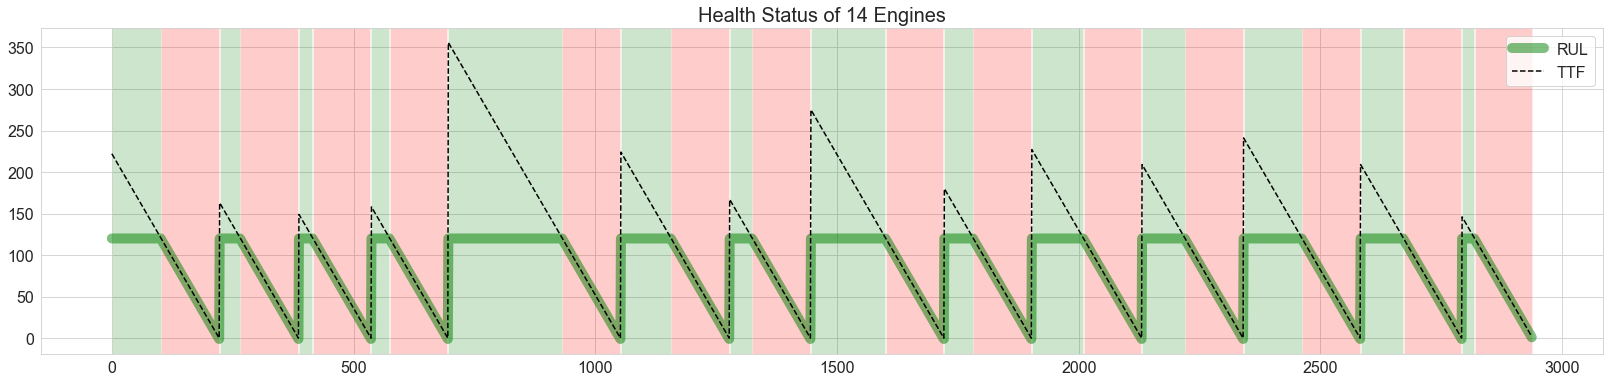

In [2]:
cmapss = CMAPSS()

p = "../../Datasets/PHM08_Challenge_Data/train.txt"
data = cmapss.load_data(p)
data = cmapss.calculate_TTF()
data = cmapss.calculate_continues_healthstate()
data = cmapss.calculate_descrete_healthstate()
cmapss.visualize_healthstatus(14) # engines to visualize

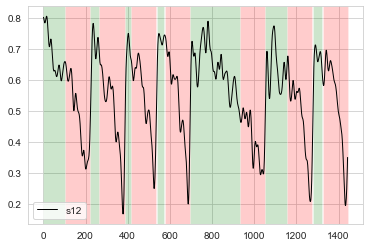

In [3]:
data = cmapss.get_univariate_cmapss("s12")
data = cmapss.minmax_scale(data)
data = cmapss.denoise_sensors()
cmapss.plot_denoised_sensors(7)

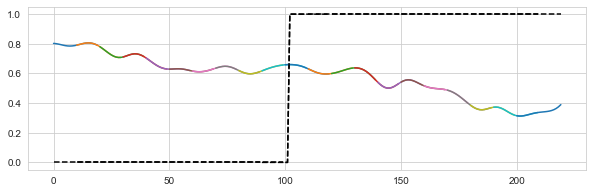

In [4]:
# So we extracted a trend --> 
# how many samples present a sin wave?
win_size=20
i=0; j=i+win_size
while j<= len(data[data.unit==1]):
    data.s12[i:j].plot(figsize=(10,3))
    data.health[i:j].plot(figsize=(10,3),c="black", linestyle="--")
    i+=(win_size//2)
    j=i+win_size

In [41]:
freq_data = cmapss.get_ffts(data, win_size)

In [45]:
# prepare data for LSTM training

## train test split
from sklearn.model_selection import GroupShuffleSplit

dev_train, dev_test = pd.DataFrame(), pd.DataFrame()
groups = freq_data.unit.values

shufflesplit = GroupShuffleSplit(n_splits=1, train_size=.7, random_state=42)
for train_idx, test_idx in shufflesplit.split(freq_data,
                                              freq_data.health.values, groups): 
    print("TRAIN size:", len(freq_data.iloc[train_idx]), 
          "TEST(Eval) size:", len(freq_data.iloc[test_idx]))
    dev_train = freq_data.iloc[train_idx].copy().reset_index(drop=True)
    dev_test = freq_data.iloc[test_idx].copy().reset_index(drop=True)

display(dev_train.head())
print(set(dev_train.unit.values))
display(dev_test.head())
print(set(dev_test.unit.values))

TRAIN size: 29640 TEST(Eval) size: 13100


,unit,fft,health
0,1,1.590964,0.0
1,1,0.008438,0.0
2,1,0.004048,0.0
3,1,0.002244,0.0
4,1,0.001610,0.0


{1, 2, 3, 4, 5, 7, 8, 9, 11, 12, 13, 14, 15, 18, 21, 22, 23, 24, 27, 28, 29, 32, 33, 34, 35, 36, 37, 38, 40, 41, 42, 43, 44, 45, 47, 48, 49, 50, 51, 52, 53, 54, 55, 58, 59, 60, 62, 63, 64, 65, 66, 71, 72, 73, 75, 77, 78, 79, 81, 82, 83, 84, 86, 88, 89, 90, 91, 92, 93, 95, 99, 100, 103, 104, 106, 107, 108, 111, 113, 115, 116, 117, 118, 121, 122, 123, 124, 125, 127, 128, 129, 130, 131, 132, 134, 135, 136, 139, 142, 143, 145, 146, 147, 149, 150, 151, 152, 154, 157, 158, 159, 160, 161, 162, 164, 166, 167, 169, 170, 172, 173, 175, 176, 180, 181, 182, 183, 184, 185, 187, 188, 189, 191, 192, 194, 196, 197, 198, 199, 200, 201, 202, 203, 205, 206, 207, 210, 211, 213, 215, 217, 218}


,unit,fft,health
0,6,1.590964,0.0
1,6,0.008438,0.0
2,6,0.004048,0.0
3,6,0.002244,0.0
4,6,0.001610,0.0


{133, 6, 137, 10, 138, 140, 141, 16, 17, 144, 19, 20, 148, 25, 26, 153, 155, 156, 30, 31, 163, 165, 39, 168, 171, 46, 174, 177, 178, 179, 56, 57, 186, 61, 190, 193, 67, 68, 69, 70, 195, 74, 76, 204, 80, 208, 209, 212, 85, 214, 87, 216, 94, 96, 97, 98, 101, 102, 105, 109, 110, 112, 114, 119, 120, 126}
